# Mumbai Flood Vulnerability Assessment: Initial Data Exploration

This notebook explores the currently available data for the Mumbai Flood Vulnerability Assessment project, focusing on the data that has been successfully collected: administrative boundaries, elevation data (DEM), and infrastructure data.

## Setup and Imports



In [1]:

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping, Point
import seaborn as sns
from pathlib import Path
import contextily as ctx

# Set matplotlib style
plt.style.use('ggplot')
%matplotlib inline




## 1. Administrative Boundaries

Let's first examine the Mumbai boundary data:





Mumbai Administrative Boundary:
CRS: EPSG:4326
Geometry type: ['Polygon' 'MultiPolygon']
Number of districts: 2

Columns:
- GID_2
- GID_0
- COUNTRY
- GID_1
- NAME_1
- NL_NAME_1
- NAME_2
- VARNAME_2
- NL_NAME_2
- TYPE_2
- ENGTYPE_2
- CC_2
- HASC_2
- geometry

Districts included:
- Mumbai City (IND.20.17_1)
- Mumbai Suburban (IND.20.18_1)

Total area: 480.31 sq km


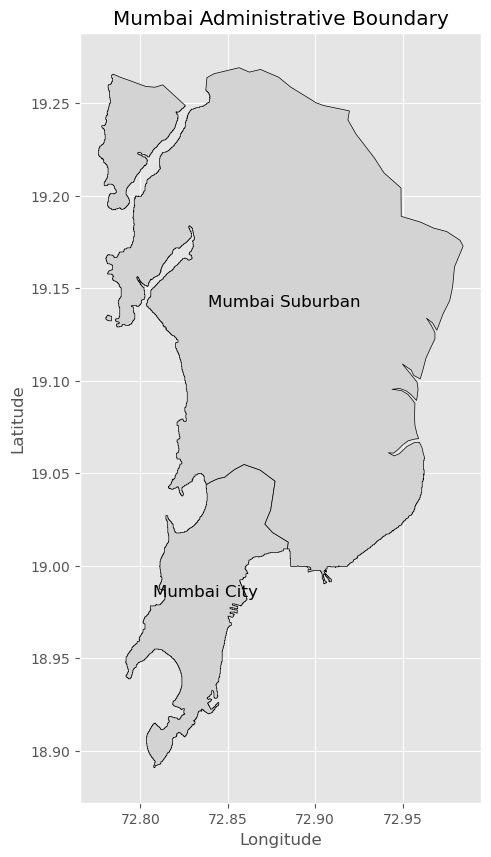

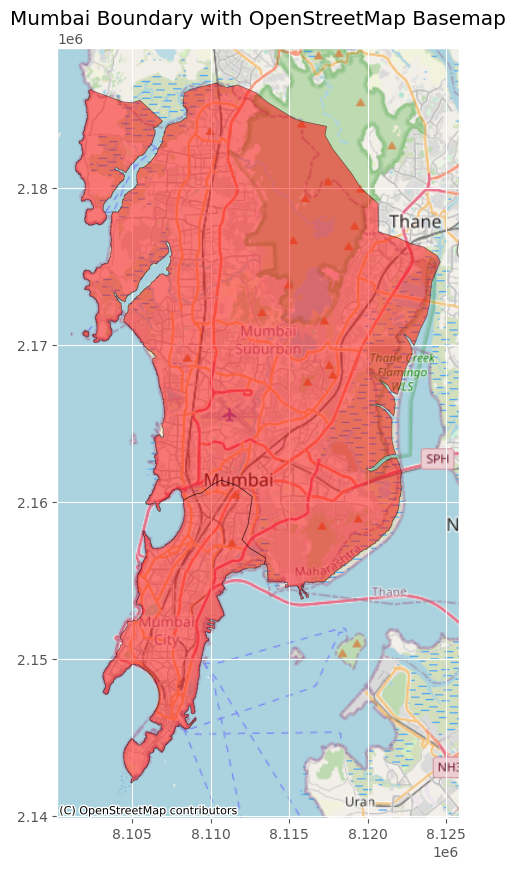

In [2]:
# Create output directory for saving figures
output_dir = Path("visualizations")
output_dir.mkdir(exist_ok=True)

# Define paths
boundary_dir = Path("data/raw/boundaries")
mumbai_boundary_file = boundary_dir / "mumbai_boundary.shp"
mumbai_wards_file = boundary_dir / "mumbai_wards.shp"

# Check if boundary file exists
if not mumbai_boundary_file.exists():
    print(f"Mumbai boundary file not found: {mumbai_boundary_file}")
    print("Please run the extract_mumbai_boundaries.py script first.")
else:
    # Load Mumbai boundary
    mumbai = gpd.read_file(mumbai_boundary_file)
    
    # Print basic information
    print("Mumbai Administrative Boundary:")
    print(f"CRS: {mumbai.crs}")
    print(f"Geometry type: {mumbai.geometry.geom_type.unique()}")
    print(f"Number of districts: {len(mumbai)}")
    print("\nColumns:")
    for col in mumbai.columns:
        print(f"- {col}")
    
    # Print district names
    print("\nDistricts included:")
    if 'NAME_2' in mumbai.columns:
        for idx, row in mumbai.iterrows():
            print(f"- {row['NAME_2']} ({row['GID_2']})")
    
    # Calculate total area
    mumbai_utm = mumbai.to_crs(epsg=32643)  # UTM Zone 43N for accurate area calculation
    total_area_sqkm = mumbai_utm.area.sum() / 1_000_000  # Convert from sq m to sq km
    print(f"\nTotal area: {total_area_sqkm:.2f} sq km")
    
    # Plot Mumbai boundary
    fig, ax = plt.subplots(figsize=(12, 10))
    mumbai.plot(ax=ax, color='lightgrey', edgecolor='black')
    
    # Add district labels if we have multiple districts
    if len(mumbai) > 1 and 'NAME_2' in mumbai.columns:
        for idx, row in mumbai.iterrows():
            centroid = row.geometry.centroid
            ax.text(centroid.x, centroid.y, row['NAME_2'], fontsize=12, 
                   ha='center', va='center', color='black')
    
    ax.set_title("Mumbai Administrative Boundary")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(output_dir / "mumbai_boundary.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot with basemap for context
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Convert to Web Mercator for contextily
    mumbai_web = mumbai.to_crs(epsg=3857)
    mumbai_web.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')
    
    # Add OpenStreetMap basemap
    try:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        plt.title("Mumbai Boundary with OpenStreetMap Basemap")
        plt.savefig(output_dir / "mumbai_boundary_with_basemap.png", dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error adding basemap: {e}")
        print("Install contextily with: pip install contextily")




In [3]:
import geopandas as gpd
from pathlib import Path

# Paths to GADM files
gadm_dir = Path("data/raw/boundaries")
gadm_level2 = gadm_dir / "gadm41_IND_2.shp"  # Level 2 contains districts

# Output path for Mumbai boundary
mumbai_boundary = gadm_dir / "mumbai_boundary.shp"

# Check if files exist
if gadm_level2.exists() and not mumbai_boundary.exists():
    # Load GADM Level 2 data (districts)
    districts = gpd.read_file(gadm_level2)
    
    # Filter for Mumbai (includes Mumbai, Mumbai Suburban)
    # First check what names are available
    print("Available districts in Maharashtra:")
    maharashtra_districts = districts[districts['NAME_1'] == 'Maharashtra']
    print(maharashtra_districts['NAME_2'].unique())
    
    # Filter for Mumbai districts
    mumbai_districts = maharashtra_districts[
        maharashtra_districts['NAME_2'].str.contains('Mumbai', case=False, na=False)]
    
    if len(mumbai_districts) > 0:
        print(f"Found {len(mumbai_districts)} Mumbai districts")
        # Save Mumbai boundaries
        mumbai_districts.to_file(mumbai_boundary)
        print(f"Mumbai boundaries saved to {mumbai_boundary}")
    else:
        print("No Mumbai districts found in GADM data. Check filtering criteria.")
else:
    if mumbai_boundary.exists():
        print(f"Mumbai boundary file already exists at {mumbai_boundary}")
    else:
        print(f"GADM Level 2 file not found at {gadm_level2}")

Mumbai boundary file already exists at data/raw/boundaries/mumbai_boundary.shp



Now let's look for ward boundaries:




Mumbai Wards:
CRS: EPSG:4326
Number of wards: 7

Columns:
- GID_3
- GID_0
- COUNTRY
- GID_1
- NAME_1
- NL_NAME_1
- GID_2
- NAME_2
- NL_NAME_2
- NAME_3
- VARNAME_3
- NL_NAME_3
- TYPE_3
- ENGTYPE_3
- CC_3
- HASC_3
- ward_id
- geometry

Total area (from wards): 480.31 sq km
Average ward size: 68.62 sq km
Smallest ward: 0.09 sq km
Largest ward: 136.14 sq km

Ward Information (Top 10 by area):
  ward_id        NAME_3   area_sqkm
4     W05  n.a. ( 1565)  136.140029
1     W02  n.a. ( 1556)  119.446675
2     W03  n.a. ( 1557)   68.657801
0     W01        Bombay   67.979067
5     W06  n.a. ( 1569)   65.916812
3     W04  n.a. ( 1558)   22.075794
6     W07  n.a. ( 1571)    0.089812


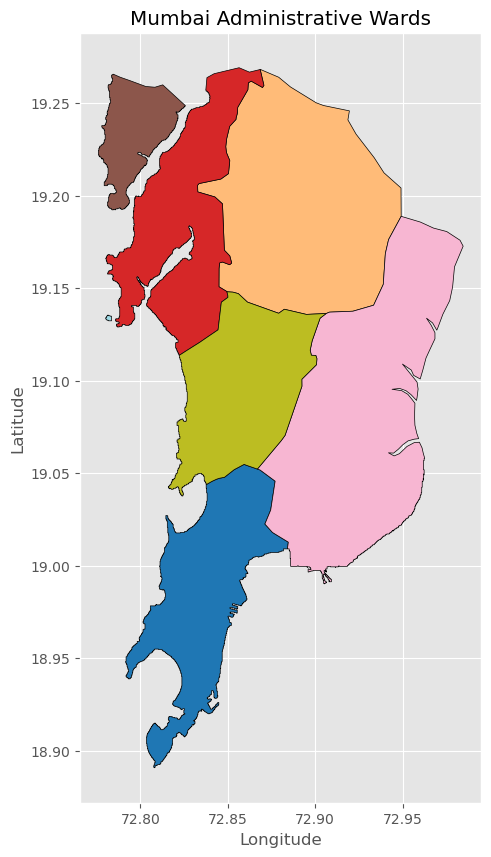

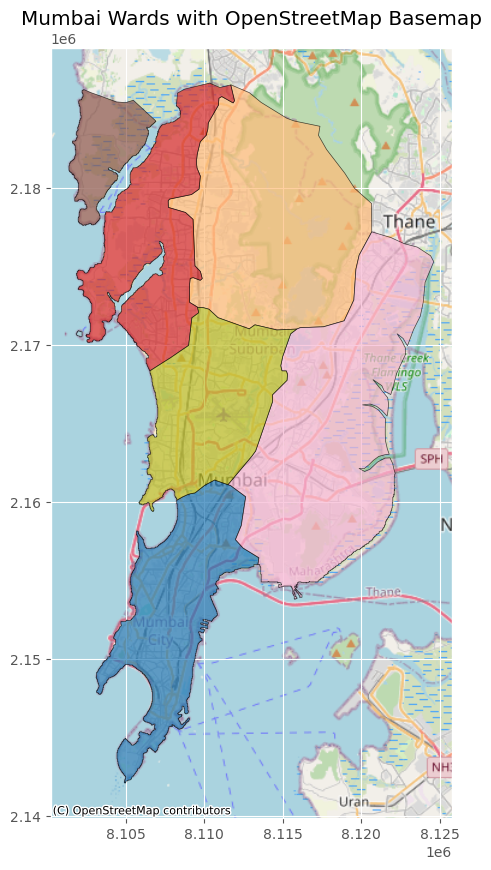

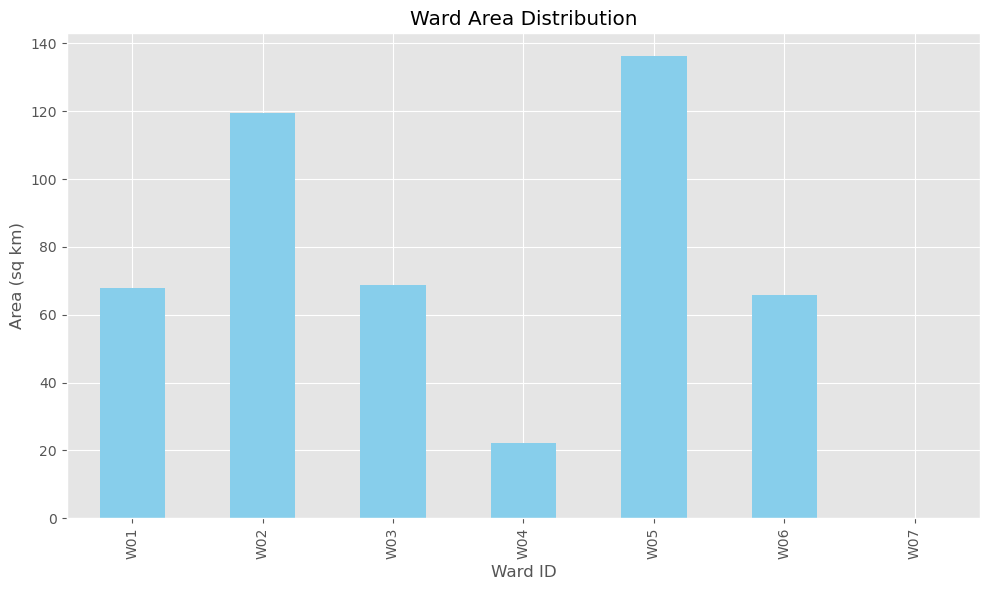

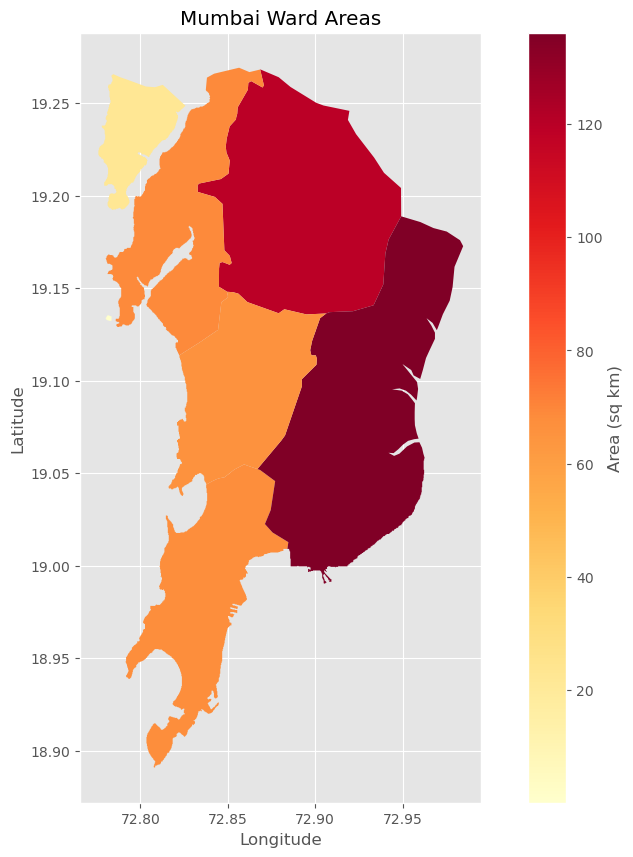

In [4]:
# Check if wards file exists
if not mumbai_wards_file.exists():
    print(f"Mumbai wards file not found: {mumbai_wards_file}")
    print("Please run the extract_mumbai_boundaries.py or download_mumbai_wards.py script.")
else:
    # Load Mumbai wards
    wards = gpd.read_file(mumbai_wards_file)
    
    # Print basic information
    print("Mumbai Wards:")
    print(f"CRS: {wards.crs}")
    print(f"Number of wards: {len(wards)}")
    print("\nColumns:")
    for col in wards.columns:
        print(f"- {col}")
    
    # Calculate ward areas
    wards_utm = wards.to_crs(epsg=32643)  # UTM Zone 43N for accurate area calculation
    wards_utm['area_sqkm'] = wards_utm.area / 1_000_000  # Convert from sq m to sq km
    wards['area_sqkm'] = wards_utm['area_sqkm']
    
    print(f"\nTotal area (from wards): {wards['area_sqkm'].sum():.2f} sq km")
    print(f"Average ward size: {wards['area_sqkm'].mean():.2f} sq km")
    print(f"Smallest ward: {wards['area_sqkm'].min():.2f} sq km")
    print(f"Largest ward: {wards['area_sqkm'].max():.2f} sq km")
    
    # Create a table of ward information
    print("\nWard Information (Top 10 by area):")
    
    # Select display columns
    display_cols = ['ward_id']
    if 'NAME_3' in wards.columns:
        display_cols.append('NAME_3')
    display_cols.append('area_sqkm')
    
    # Show top 10 largest wards
    print(wards.sort_values('area_sqkm', ascending=False)[display_cols].head(10))
    
    # Plot wards
    fig, ax = plt.subplots(figsize=(12, 10))
    wards.plot(ax=ax, column='ward_id', cmap='tab20', edgecolor='black')
    ax.set_title("Mumbai Administrative Wards")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(output_dir / "mumbai_wards.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot wards with basemap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Convert to Web Mercator for contextily
    wards_web = wards.to_crs(epsg=3857)
    wards_web.plot(ax=ax, column='ward_id', cmap='tab20', edgecolor='black', alpha=0.7)
    
    # Add OpenStreetMap basemap
    try:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        plt.title("Mumbai Wards with OpenStreetMap Basemap")
        plt.savefig(output_dir / "mumbai_wards_with_basemap.png", dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error adding basemap: {e}")
    
    # Plot ward area distribution
    plt.figure(figsize=(10, 6))
    wards['area_sqkm'].plot(kind='bar', color='skyblue')
    plt.title("Ward Area Distribution")
    plt.xlabel("Ward ID")
    plt.ylabel("Area (sq km)")
    plt.xticks(range(len(wards)), wards['ward_id'], rotation=90)
    plt.tight_layout()
    plt.savefig(output_dir / "ward_area_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create a heatmap/choropleth of ward areas
    fig, ax = plt.subplots(figsize=(12, 10))
    wards.plot(column='area_sqkm', ax=ax, legend=True, cmap='YlOrRd', 
              legend_kwds={'label': "Area (sq km)"})
    ax.set_title("Mumbai Ward Areas")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(output_dir / "ward_area_choropleth.png", dpi=300, bbox_inches='tight')
    plt.show()




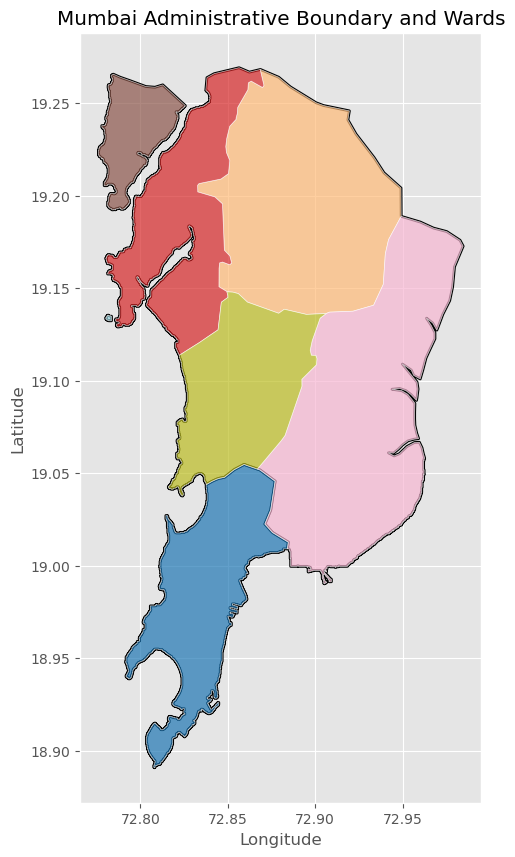

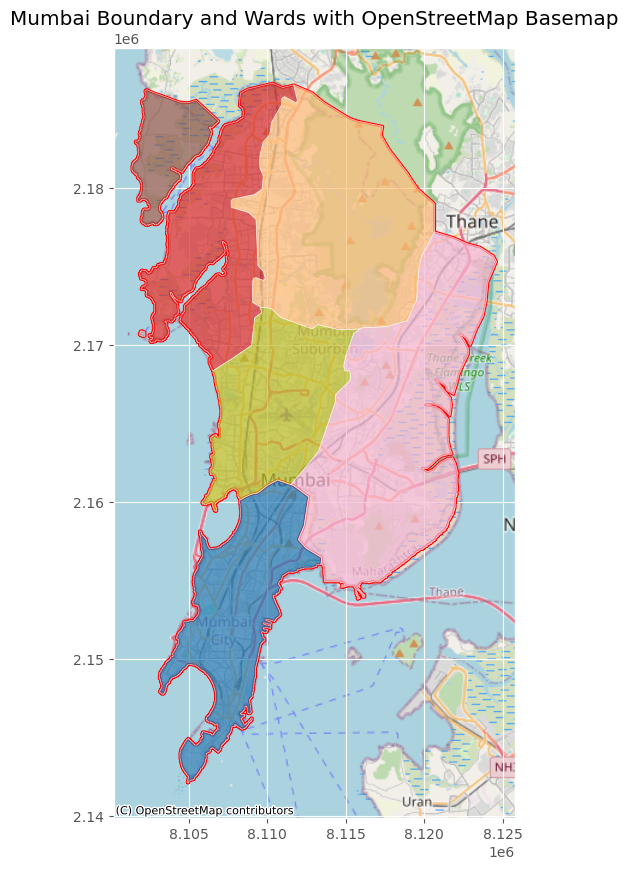


Wards by District:

Mumbai City: 3 wards
['W01', 'W05', 'W06']


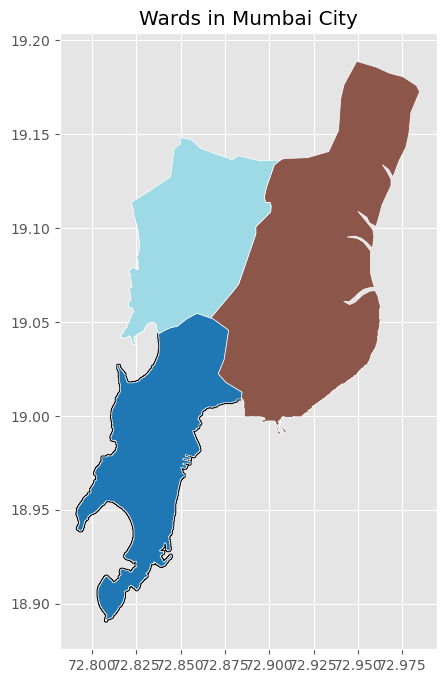


Mumbai Suburban: 7 wards
['W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07']


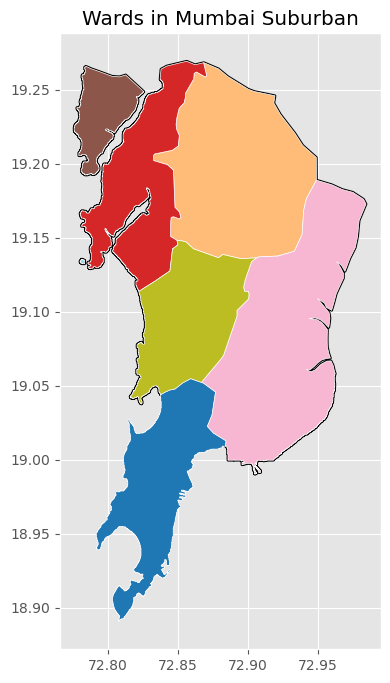

In [5]:
# Overlay Mumbai Boundary and Wards


# Check if both files exist
if mumbai_boundary_file.exists() and mumbai_wards_file.exists():
    # Load Mumbai boundary and wards
    mumbai = gpd.read_file(mumbai_boundary_file)
    wards = gpd.read_file(mumbai_wards_file)
    
    # Plot Mumbai boundary and wards together
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot boundary first
    mumbai.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
    
    # Plot wards with color
    wards.plot(ax=ax, column='ward_id', cmap='tab20', edgecolor='white', 
              linewidth=0.5, alpha=0.7)
    
    ax.set_title("Mumbai Administrative Boundary and Wards")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(output_dir / "mumbai_boundary_and_wards.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot with basemap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Convert to Web Mercator for contextily
    mumbai_web = mumbai.to_crs(epsg=3857)
    wards_web = wards.to_crs(epsg=3857)
    
    # Plot layers
    mumbai_web.plot(ax=ax, color='none', edgecolor='red', linewidth=2)
    wards_web.plot(ax=ax, column='ward_id', cmap='tab20', edgecolor='white', 
                 linewidth=0.5, alpha=0.7)
    
    # Add OpenStreetMap basemap
    try:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        plt.title("Mumbai Boundary and Wards with OpenStreetMap Basemap")
        plt.savefig(output_dir / "mumbai_boundary_and_wards_with_basemap.png", dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error adding basemap: {e}")
    
    # Check for ward-district overlap
    try:
        # See which wards are in which districts
        if len(mumbai) > 1:
            print("\nWards by District:")
            
            for idx, district in mumbai.iterrows():
                district_name = district['NAME_2'] if 'NAME_2' in mumbai.columns else f"District {idx+1}"
                district_geometry = district.geometry
                
                # Find wards in this district
                wards_in_district = wards[wards.geometry.intersects(district_geometry)]
                
                print(f"\n{district_name}: {len(wards_in_district)} wards")
                if len(wards_in_district) > 0:
                    print(wards_in_district['ward_id'].tolist())
                    
                    # Plot this district and its wards
                    fig, ax = plt.subplots(figsize=(10, 8))
                    gpd.GeoDataFrame(geometry=[district_geometry], crs=mumbai.crs).plot(
                        ax=ax, color='none', edgecolor='black', linewidth=2)
                    wards_in_district.plot(ax=ax, column='ward_id', cmap='tab20', 
                                         edgecolor='white', linewidth=0.5)
                    ax.set_title(f"Wards in {district_name}")
                    plt.savefig(output_dir / f"wards_in_{district_name.replace(' ', '_')}.png", 
                              dpi=300, bbox_inches='tight')
                    plt.show()
    except Exception as e:
        print(f"Error analyzing district-ward relationships: {e}")




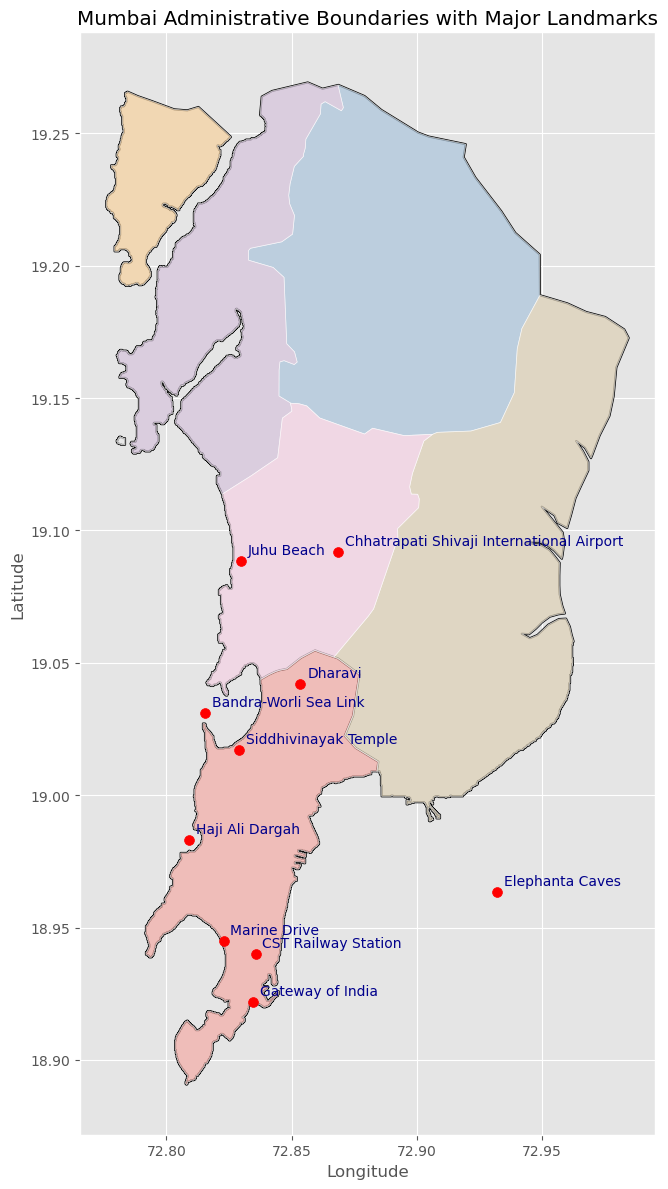

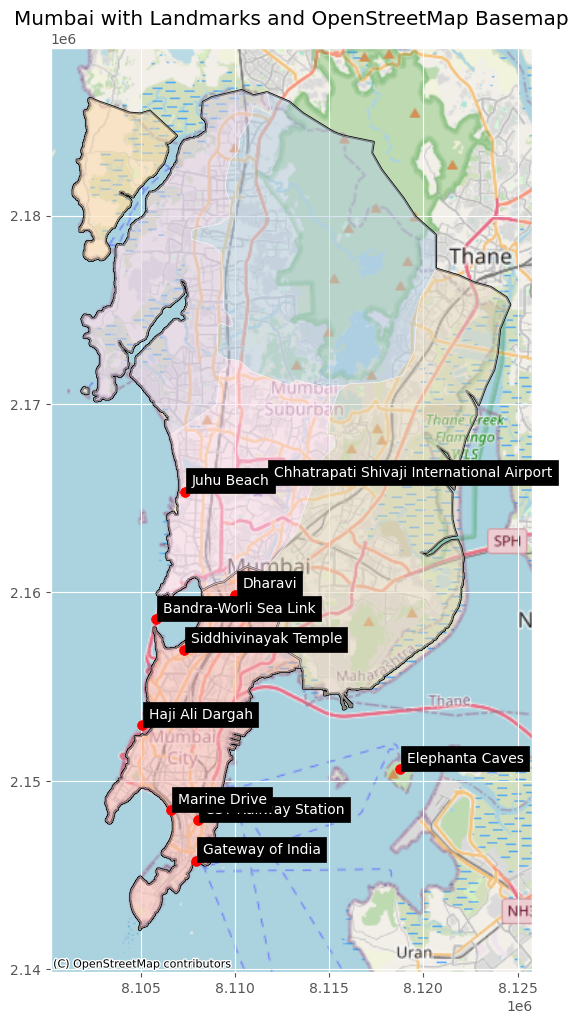


Landmarks and their Wards:
Gateway of India is in W01 (Bombay)
CST Railway Station is in W01 (Bombay)
Bandra-Worli Sea Link is not within any ward boundary
Juhu Beach is in W06 (n.a. ( 1569))
Chhatrapati Shivaji International Airport is in W06 (n.a. ( 1569))
Elephanta Caves is not within any ward boundary
Marine Drive is in W01 (Bombay)
Haji Ali Dargah is not within any ward boundary
Siddhivinayak Temple is in W01 (Bombay)
Dharavi is in W01 (Bombay)


In [6]:
## 4. Add Important Landmarks


# Define important Mumbai landmarks for reference
landmarks = {
    "Gateway of India": (72.8347, 18.9220),
    "CST Railway Station": (72.8356, 18.9402),
    "Bandra-Worli Sea Link": (72.8156, 19.0309),
    "Juhu Beach": (72.8296, 19.0883),
    "Chhatrapati Shivaji International Airport": (72.8685, 19.0919),
    "Elephanta Caves": (72.9319, 18.9633),
    "Marine Drive": (72.8228, 18.9448),
    "Haji Ali Dargah": (72.8090, 18.9830),
    "Siddhivinayak Temple": (72.8289, 19.0170),
    "Dharavi": (72.8535, 19.0420)
}

# Create a GeoDataFrame of landmarks
landmark_points = [Point(lon, lat) for lon, lat in landmarks.values()]
landmark_df = gpd.GeoDataFrame(
    {'name': landmarks.keys(), 'geometry': landmark_points}, 
    crs="EPSG:4326"
)

# Check if boundary files exist
if mumbai_boundary_file.exists() and mumbai_wards_file.exists():
    # Load Mumbai boundary and wards
    mumbai = gpd.read_file(mumbai_boundary_file)
    wards = gpd.read_file(mumbai_wards_file)
    
    # Plot Mumbai with landmarks
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Plot boundary first
    mumbai.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1.5)
    
    # Plot wards with color
    wards.plot(ax=ax, cmap='Pastel1', edgecolor='white', linewidth=0.5, alpha=0.7)
    
    # Plot landmarks
    landmark_df.plot(ax=ax, color='red', markersize=50)
    
    # Add landmark labels
    for idx, row in landmark_df.iterrows():
        ax.annotate(row['name'], xy=(row.geometry.x, row.geometry.y),
                  xytext=(5, 5), textcoords="offset points",
                  fontsize=10, color='darkblue')
    
    ax.set_title("Mumbai Administrative Boundaries with Major Landmarks")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.tight_layout()
    plt.savefig(output_dir / "mumbai_with_landmarks.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot with basemap
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Convert to Web Mercator for contextily
    mumbai_web = mumbai.to_crs(epsg=3857)
    wards_web = wards.to_crs(epsg=3857)
    landmark_web = landmark_df.to_crs(epsg=3857)
    
    # Plot layers
    mumbai_web.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)
    wards_web.plot(ax=ax, cmap='Pastel1', edgecolor='white', linewidth=0.5, alpha=0.5)
    landmark_web.plot(ax=ax, color='red', markersize=50)
    
    # Add landmark labels
    for idx, row in landmark_web.iterrows():
        ax.annotate(row['name'], xy=(row.geometry.x, row.geometry.y),
                  xytext=(5, 5), textcoords="offset points",
                  fontsize=10, color='white', backgroundcolor='black')
    
    # Add OpenStreetMap basemap
    try:
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
        plt.title("Mumbai with Landmarks and OpenStreetMap Basemap")
        plt.savefig(output_dir / "mumbai_landmarks_with_basemap.png", dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error adding basemap: {e}")
    
    # Find which ward each landmark is in
    print("\nLandmarks and their Wards:")
    
    for idx, landmark in landmark_df.iterrows():
        # Find which ward contains this landmark
        containing_ward = None
        for ward_idx, ward in wards.iterrows():
            if ward.geometry.contains(landmark.geometry):
                containing_ward = ward
                break
        
        if containing_ward is not None:
            ward_id = containing_ward['ward_id'] if 'ward_id' in containing_ward else f"Ward {ward_idx+1}"
            ward_name = containing_ward['NAME_3'] if 'NAME_3' in containing_ward else ward_id
            print(f"{landmark['name']} is in {ward_id} ({ward_name})")
        else:
            print(f"{landmark['name']} is not within any ward boundary")




Creating ward statistics table...
Ward statistics saved to visualizations/mumbai_ward_statistics.csv

Ward Statistics Summary:


/tmp/ipykernel_864416/1652478648.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = wards.centroid


        area_sqkm  perimeter_km  compactness  centroid_lon  centroid_lat
count    7.000000      7.000000     7.000000      7.000000      7.000000
mean    68.615142     51.383130     0.366229     72.845597     19.130495
std     48.326622     29.740571     0.214527      0.051532      0.084095
min      0.089812      1.379855     0.132419     72.781988     18.985528
25%     43.996303     37.047175     0.210507     72.810998     19.089625
50%     67.979067     47.030857     0.290382     72.837331     19.133784
75%     94.052238     78.228980     0.520592     72.875384     19.190147
max    136.140029     80.718890     0.678607     72.927095     19.234605


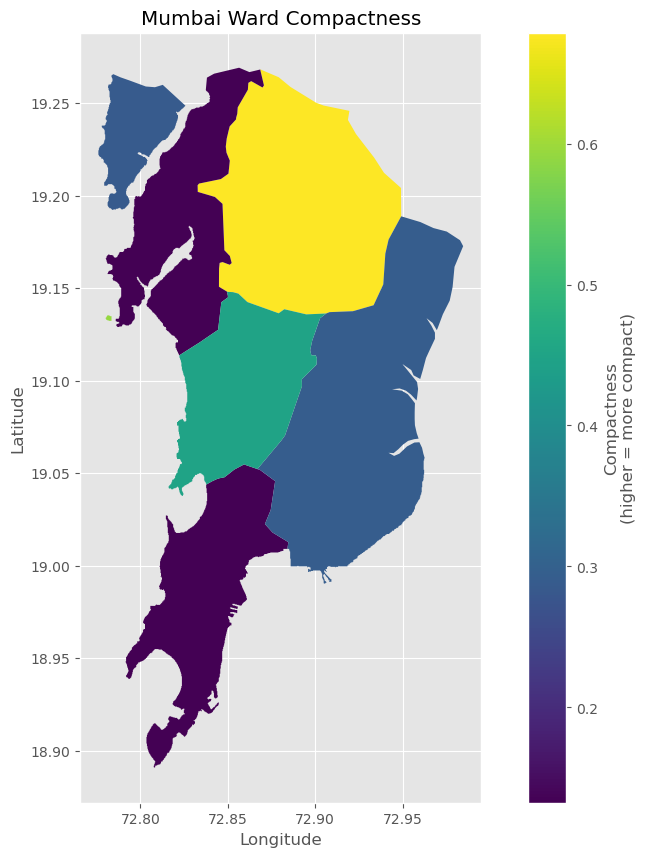

In [7]:
# 5. Calculate Ward Statistics for Future Analysis
# Check if ward file exists
if mumbai_wards_file.exists():
    # Load Mumbai wards
    wards = gpd.read_file(mumbai_wards_file)
    # Calculate ward areas
    wards_utm = wards.to_crs(epsg=32643) # UTM Zone 43N for accurate area calculation
    wards['area_sqkm'] = wards_utm.area / 1_000_000 # Convert from sq m to sq km
    # Create ward statistics table
    print("Creating ward statistics table...")
    # Select columns for the statistics table
    stat_cols = ['ward_id']
    if 'NAME_3' in wards.columns:
        stat_cols.append('NAME_3')
    if 'VARNAME_3' in wards.columns:
        stat_cols.append('VARNAME_3')
    stat_cols.append('area_sqkm')
    # Create statistic dataframe
    ward_stats = wards[stat_cols].copy()
    # Add perimeter
    ward_stats['perimeter_km'] = wards_utm.length / 1000 # Convert from m to km
    # Add compactness ratio (area / perimeter²) - higher values mean more compact shapes
    ward_stats['compactness'] = (4 * np.pi * wards_utm.area) / (wards_utm.length ** 2)
    # Calculate centroid coordinates
    centroids = wards.centroid
    ward_stats['centroid_lon'] = centroids.x
    ward_stats['centroid_lat'] = centroids.y
    # Save ward statistics
    stats_file = output_dir / "mumbai_ward_statistics.csv"
    ward_stats.to_csv(stats_file, index=False)
    print(f"Ward statistics saved to {stats_file}")
    # Display statistics
    print("\nWard Statistics Summary:")
    print(ward_stats.describe())
    # Add compactness to wards GeoDataFrame
    wards['compactness'] = ward_stats['compactness']
    # Plot compactness
    fig, ax = plt.subplots(figsize=(12, 10))
    wards.plot(column='compactness', ax=ax, legend=True, cmap='viridis',
               legend_kwds={'label': "Compactness\n(higher = more compact)"})
    ax.set_title("Mumbai Ward Compactness")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.savefig(output_dir / "ward_compactness.png", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Ward file not found at:", mumbai_wards_file)

In [8]:
## 6. Export to Different Formats for Other Applications


# Check if boundary files exist
if mumbai_boundary_file.exists() and mumbai_wards_file.exists():
    # Load Mumbai boundary and wards
    mumbai = gpd.read_file(mumbai_boundary_file)
    wards = gpd.read_file(mumbai_wards_file)
    
    # Create export directory
    export_dir = Path("data/processed/boundaries")
    export_dir.mkdir(exist_ok=True, parents=True)
    
    print("Exporting boundaries to different formats...")
    
    # Export to GeoJSON (for web applications)
    mumbai.to_file(export_dir / "mumbai_boundary.geojson", driver="GeoJSON")
    wards.to_file(export_dir / "mumbai_wards.geojson", driver="GeoJSON")
    print("Exported to GeoJSON format")
    
    # Export to KML (for Google Earth)
    try:
        mumbai.to_file(export_dir / "mumbai_boundary.kml", driver="KML")
        wards.to_file(export_dir / "mumbai_wards.kml", driver="KML")
        print("Exported to KML format")
    except Exception as e:
        print(f"Error exporting to KML: {e}")
    
    # Export to CSV (with WKT geometry for simple applications)
    mumbai['geometry_wkt'] = mumbai.geometry.apply(lambda g: g.wkt)
    wards['geometry_wkt'] = wards.geometry.apply(lambda g: g.wkt)
    
    mumbai_csv = mumbai.drop(columns='geometry')
    wards_csv = wards.drop(columns='geometry')
    
    mumbai_csv.to_csv(export_dir / "mumbai_boundary.csv", index=False)
    wards_csv.to_csv(export_dir / "mumbai_wards.csv", index=False)
    print("Exported to CSV format with WKT geometry")
    
    # Export UTM projected versions (for accurate distance/area calculations)
    mumbai.to_crs(epsg=32643).to_file(export_dir / "mumbai_boundary_utm43n.shp")
    wards.to_crs(epsg=32643).to_file(export_dir / "mumbai_wards_utm43n.shp")
    print("Exported to UTM Zone 43N projection")
    
    print(f"All exports saved to {export_dir}")




Exporting boundaries to different formats...
Exported to GeoJSON format
Exported to KML format
Exported to CSV format with WKT geometry
Exported to UTM Zone 43N projection
All exports saved to data/processed/boundaries


/tmp/ipykernel_864416/4275289146.py:41: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mumbai.to_crs(epsg=32643).to_file(export_dir / "mumbai_boundary_utm43n.shp")
/home/vi/miniconda3/envs/flood-assessment/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'geometry_wkt' to 'geometry_w'
  ogr_write(
/home/vi/miniconda3/envs/flood-assessment/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 'POLYGON ((72.88412475600006 19.00902938900009, 72.88181305000012 19.00902938900009, 72.88181305000012 19.00875282400017, 72.88180542000003 19.007917405000057, 72.88069152800006 19.007921220000128, 72.88069152800006 19.00764274700009, 72.87985992400019 19.00764274700009, 72.87985992400019 19.007360458999983, 72.87902832000009 19.007360458999983, 72.87902832000009 19.007083893000015, 72.87430572600016 19.007083893000015, 72.87430572600016 19.006805419999978, 72.87319183400018 19.006

In [9]:
## 7. Conclusions


print("Administrative Boundaries Exploration Summary:")
print("---------------------------------------------")

# Check for boundary file
if mumbai_boundary_file.exists():
    mumbai = gpd.read_file(mumbai_boundary_file)
    print(f"- Mumbai boundary consists of {len(mumbai)} district(s)")
    
    # Get total area
    mumbai_utm = mumbai.to_crs(epsg=32643)
    total_area_sqkm = mumbai_utm.area.sum() / 1_000_000
    print(f"- Total administrative area: {total_area_sqkm:.2f} sq km")
else:
    print("- Mumbai boundary file not found")

# Check for ward file
if mumbai_wards_file.exists():
    wards = gpd.read_file(mumbai_wards_file)
    print(f"- Mumbai is divided into {len(wards)} administrative wards")
    
    # If we have ward areas
    if 'area_sqkm' in wards.columns:
        print(f"- Average ward size: {wards['area_sqkm'].mean():.2f} sq km")
        print(f"- Ward size range: {wards['area_sqkm'].min():.2f} - {wards['area_sqkm'].max():.2f} sq km")
else:
    print("- Mumbai ward file not found")

print("\nNext Steps:")
print("----------")
print("1. Integrate these boundary files with other data layers (elevation, infrastructure, etc.)")
print("2. Use the ward boundaries for zonal statistics calculations")
print("3. Develop ward-level vulnerability indices")
print("4. Create interactive web maps using the exported GeoJSON files")



Administrative Boundaries Exploration Summary:
---------------------------------------------
- Mumbai boundary consists of 2 district(s)
- Total administrative area: 480.31 sq km
- Mumbai is divided into 7 administrative wards

Next Steps:
----------
1. Integrate these boundary files with other data layers (elevation, infrastructure, etc.)
2. Use the ward boundaries for zonal statistics calculations
3. Develop ward-level vulnerability indices
4. Create interactive web maps using the exported GeoJSON files


## 2. Digital Elevation Model (DEM)

Now let's explore the DEM data:




CRS: EPSG:4326
Dimensions: 40 x 55
Resolution: (0.010573500688852589, 0.010573500688852589)
Bounds: BoundingBox(left=72.67494596150834, bottom=18.822731593095607, right=73.09788598906245, top=19.4042741309825)
Nodata value: -9999.0
Min elevation: -71.14 m
Max elevation: 455.50 m
Mean elevation: -32.56 m
Standard deviation: 59.55 m


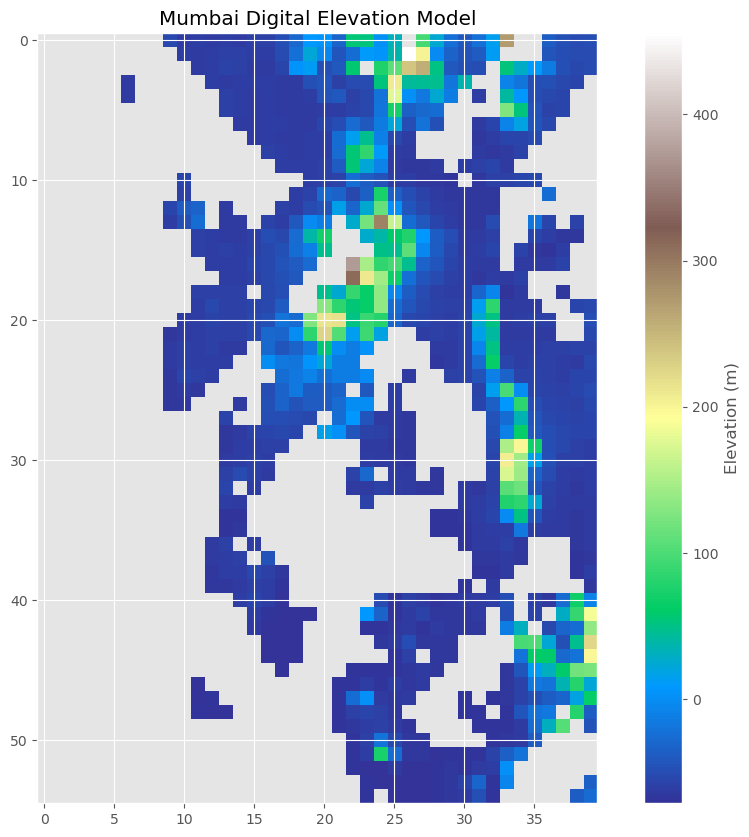

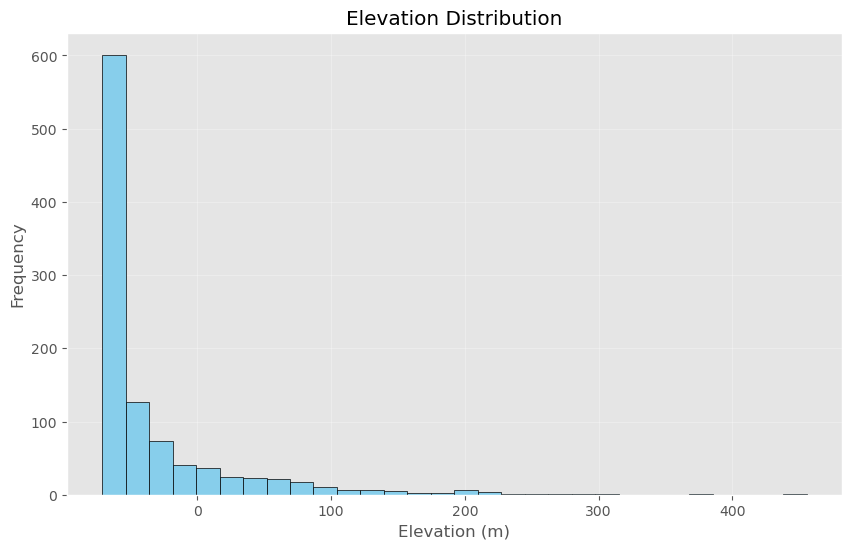

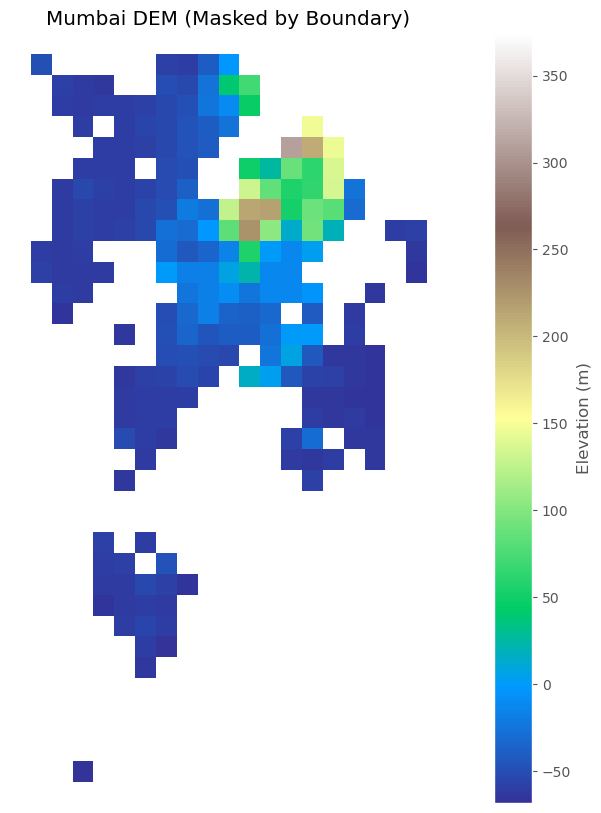

In [10]:

# Check if the DEM file exists
dem_file = Path("data/raw/dem/mumbai_dem.tif")
clipped_dem_file = Path("data/processed/hydrology/mumbai_dem_clipped.tif")
dem_path = clipped_dem_file if clipped_dem_file.exists() else dem_file

if dem_path.exists():
    # Open the DEM file
    with rasterio.open(dem_path) as src:
        print(f"CRS: {src.crs}")
        print(f"Dimensions: {src.width} x {src.height}")
        print(f"Resolution: {src.res}")
        print(f"Bounds: {src.bounds}")

        # Read the DEM data
        dem = src.read(1)

        # Handle nodata values
        if src.nodata is not None:
            print(f"Nodata value: {src.nodata}")
            dem = np.where(dem == src.nodata, np.nan, dem)

        # Calculate basic statistics
        print(f"Min elevation: {np.nanmin(dem):.2f} m")
        print(f"Max elevation: {np.nanmax(dem):.2f} m")
        print(f"Mean elevation: {np.nanmean(dem):.2f} m")
        print(f"Standard deviation: {np.nanstd(dem):.2f} m")

        # Plot the DEM
        fig, ax = plt.subplots(figsize=(12, 10))
        img = ax.imshow(dem, cmap='terrain')
        plt.colorbar(img, ax=ax, label='Elevation (m)')
        plt.title("Mumbai Digital Elevation Model")
        plt.show()

        # Plot elevation histogram
        plt.figure(figsize=(10, 6))
        plt.hist(dem[~np.isnan(dem)].flatten(), bins=30, color='skyblue', edgecolor='black')
        plt.title("Elevation Distribution")
        plt.xlabel("Elevation (m)")
        plt.ylabel("Frequency")
        plt.grid(True, alpha=0.3)
        plt.show()

        # If we have the boundary, mask the DEM with it and plot
        boundary_file = Path("data/raw/boundaries/mumbai_wards.shp")
        if boundary_file.exists():
            try:
                boundary = gpd.read_file(boundary_file)
                # Make sure boundary is in the same CRS as raster
                boundary = boundary.to_crs(src.crs)
                # Get geometry as GeoJSON-like dict
                shapes = [mapping(geom) for geom in boundary.geometry]
                # Mask the raster
                out_image, out_transform = mask(src, shapes, crop=True)
                # Plot the masked DEM
                fig, ax = plt.subplots(figsize=(12, 10))
                masked_dem = out_image[0]
                if src.nodata is not None:
                    masked_dem = np.where(masked_dem == src.nodata, np.nan, masked_dem)
                img = ax.imshow(masked_dem, cmap='terrain')
                plt.colorbar(img, ax=ax, label='Elevation (m)')
                plt.title("Mumbai DEM (Masked by Boundary)")
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Error masking DEM with boundary: {e}")
else:
    print("DEM file not found at:", dem_file)
    print("Clipped DEM file not found at:", clipped_dem_file)

```
Define the bounding box for Mumbai (approximate coordinates)

min_lon, min_lat = 72.67494596150834, 18.822731593095607
max_lon, max_lat = 73.09788598906245, 19.4042741309825
```

## 3. Infrastructure Data

Let's examine what infrastructure data we have:




Infrastructure files found: ['mumbai_critical.shp', 'mumbai_roads.shp', 'mumbai_buildings.shp', 'mumbai_water.shp', 'mumbai_drainage.shp']

mumbai_roads.shp:
  CRS: EPSG:4326
  Features: 60208
  Geometry types: ['LineString']
  Columns: ['osm_id', 'name', 'highway', 'waterway', 'aerialway', 'barrier', 'man_made', 'railway', 'z_order', 'other_tags', 'geometry']


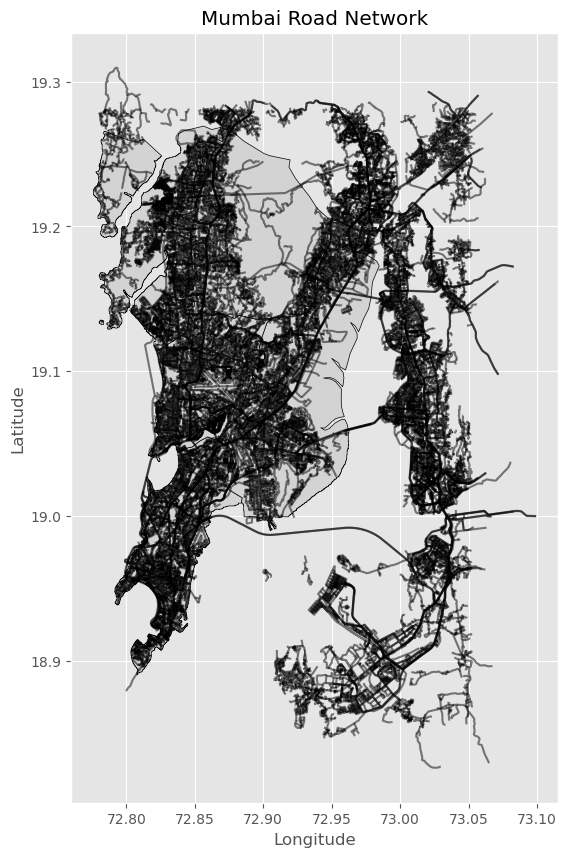


mumbai_water.shp:
  CRS: EPSG:4326
  Features: 722
  Geometry types: ['Polygon']
  Columns: ['osm_id', 'osm_way_id', 'name', 'type', 'aeroway', 'amenity', 'admin_leve', 'barrier', 'boundary', 'building', 'craft', 'geological', 'historic', 'land_area', 'landuse', 'leisure', 'man_made', 'military', 'natural', 'office', 'place', 'shop', 'sport', 'tourism', 'other_tags', 'geometry']


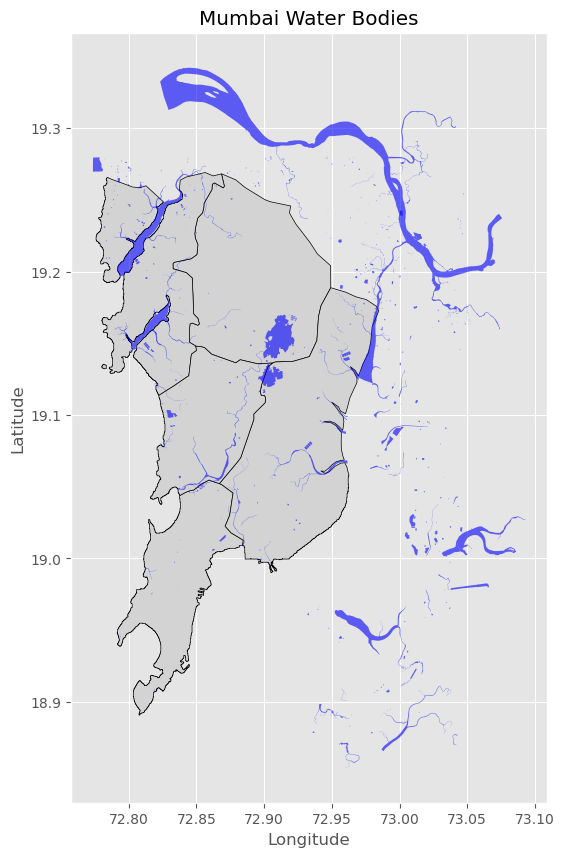


mumbai_drainage.shp:
  CRS: EPSG:4326
  Features: 1154
  Geometry types: ['LineString']
  Columns: ['osm_id', 'name', 'highway', 'waterway', 'aerialway', 'barrier', 'man_made', 'railway', 'z_order', 'other_tags', 'geometry']


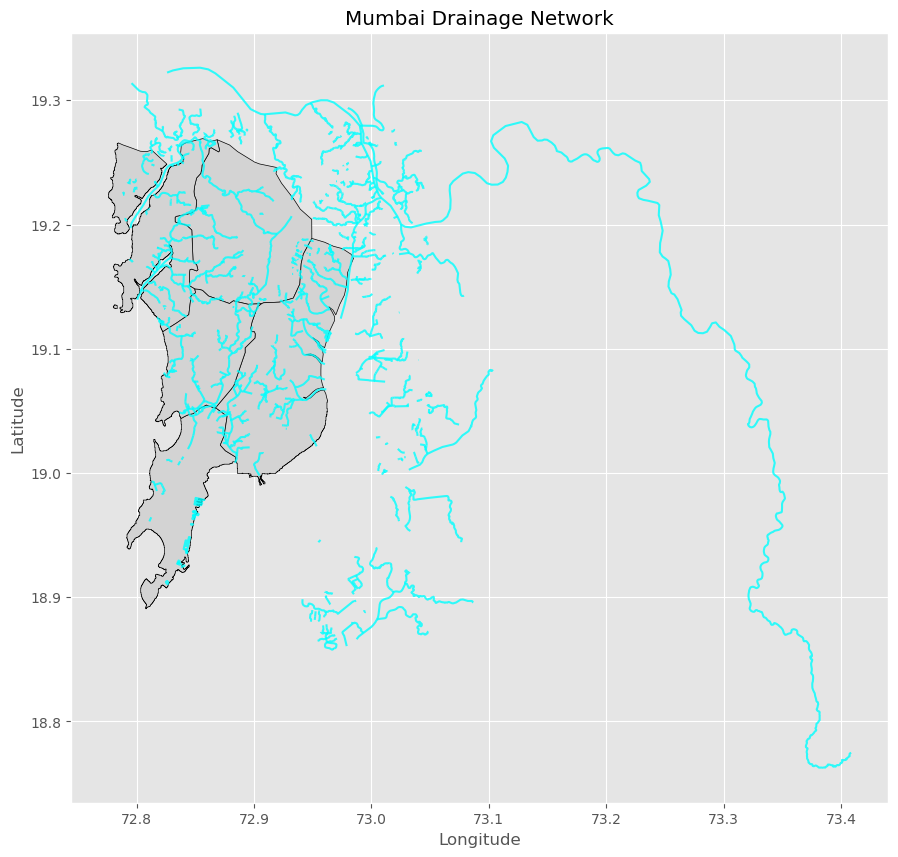


mumbai_buildings.shp:
  CRS: EPSG:4326
  Features: 161652
  Geometry types: ['Polygon']
  Columns: ['osm_id', 'osm_way_id', 'name', 'type', 'aeroway', 'amenity', 'admin_leve', 'barrier', 'boundary', 'building', 'craft', 'geological', 'historic', 'land_area', 'landuse', 'leisure', 'man_made', 'military', 'natural', 'office', 'place', 'shop', 'sport', 'tourism', 'other_tags', 'geometry']


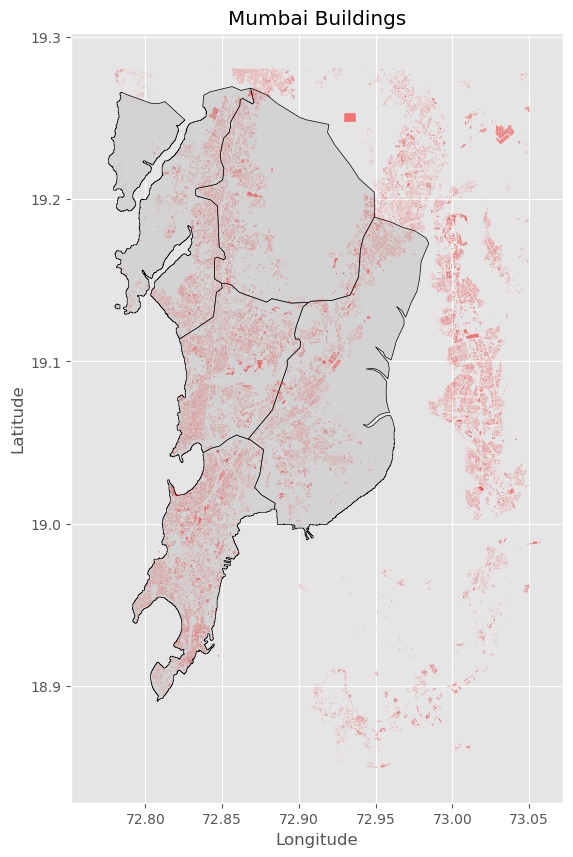


mumbai_critical.shp:
  CRS: EPSG:4326
  Features: 20
  Geometry types: ['Point']
  Columns: ['amenity', 'name', 'osm_id', 'geometry']


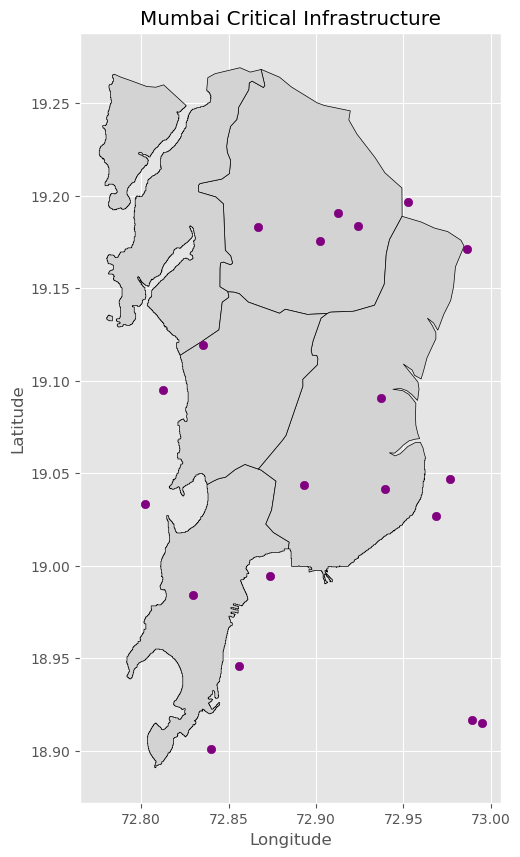

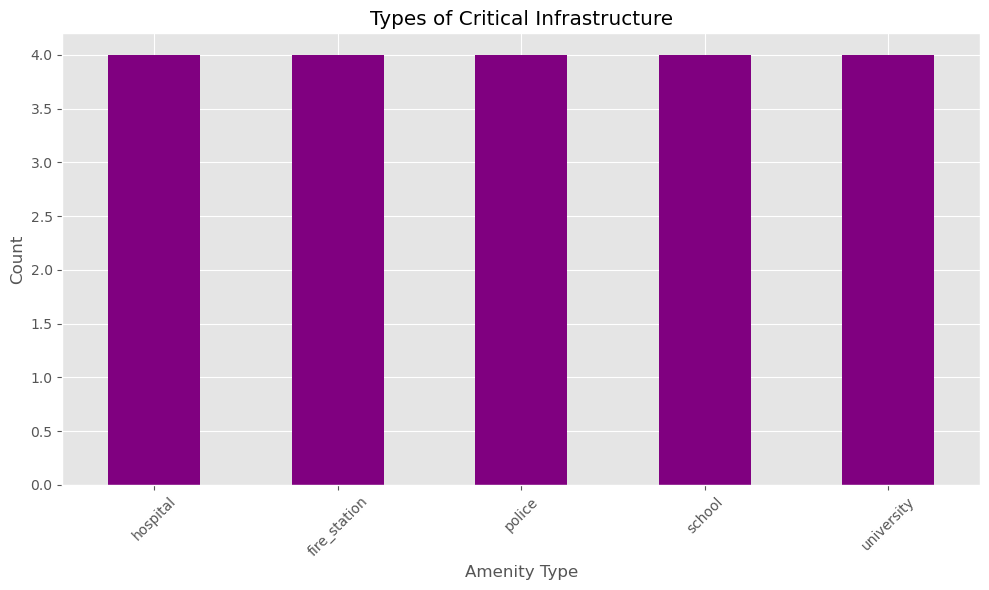

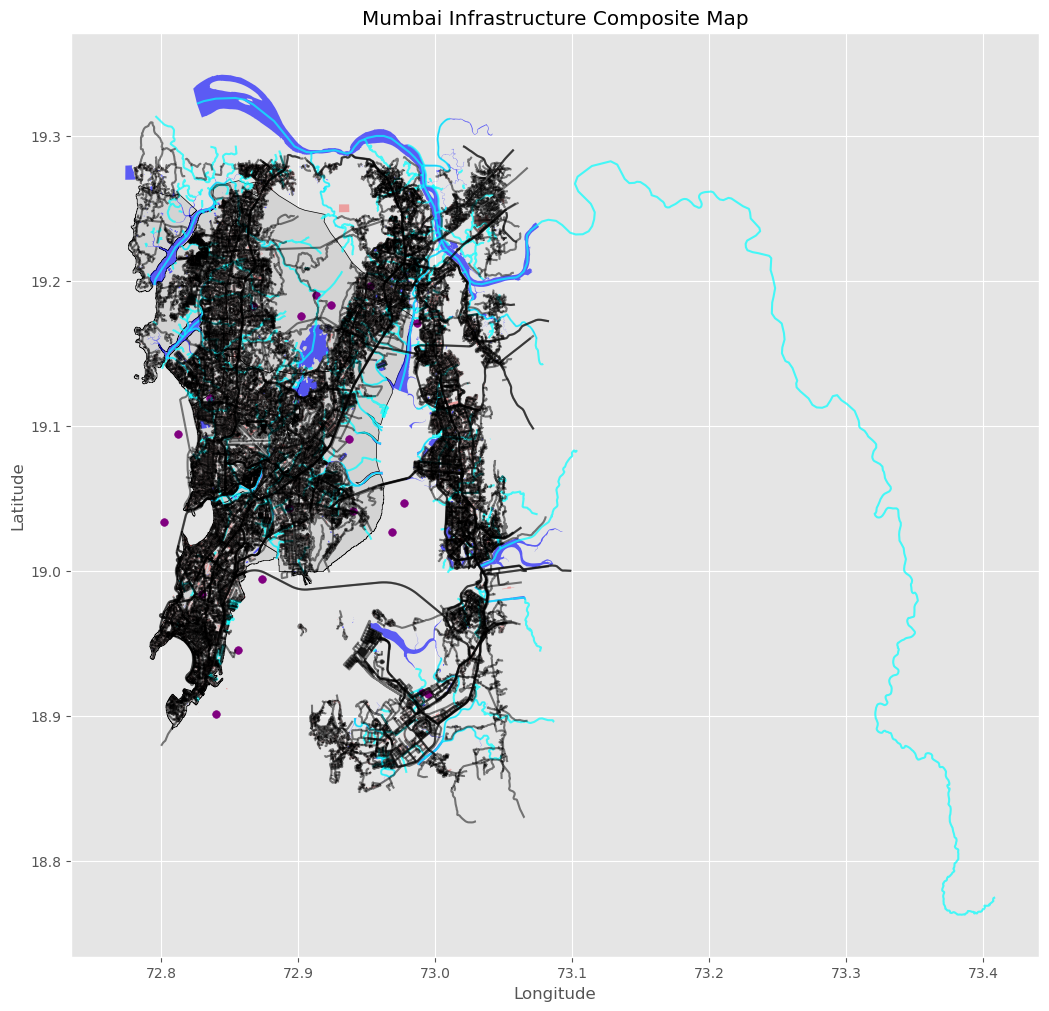

In [11]:
# Check what infrastructure files we have
infra_dir = Path("data/raw/infrastructure")
infra_files = list(infra_dir.glob("*.shp"))

if infra_files:
    print(f"Infrastructure files found: {[f.name for f in infra_files]}")
    
    # Create a function to load and plot each infrastructure layer
    def explore_infra_layer(file_name, color='blue', alpha=0.7, title=None):
        file_path = infra_dir / file_name
        if file_path.exists():
            # Load the data
            data = gpd.read_file(file_path)
            print(f"\n{file_name}:")
            print(f"  CRS: {data.crs}")
            print(f"  Features: {len(data)}")
            print(f"  Geometry types: {data.geometry.geom_type.unique()}")
            print(f"  Columns: {data.columns.tolist()}")
            
            # Plot the data
            fig, ax = plt.subplots(figsize=(12, 10))
            
            # If we have a boundary, plot it first
            if boundary_file.exists():
                boundary = gpd.read_file(boundary_file)
                boundary.plot(ax=ax, color='lightgrey', edgecolor='black')
            
            # Plot the infrastructure data
            data.plot(ax=ax, color=color, alpha=alpha)
            plt.title(title or f"Mumbai {file_name}")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.show()
            
            return data
        else:
            print(f"{file_name} not found")
            return None
    
    # Explore each infrastructure layer
    if (infra_dir / "mumbai_roads.shp").exists():
        roads = explore_infra_layer("mumbai_roads.shp", color='black', alpha=0.5, title="Mumbai Road Network")
    
    if (infra_dir / "mumbai_water.shp").exists():
        water = explore_infra_layer("mumbai_water.shp", color='blue', alpha=0.6, title="Mumbai Water Bodies")
    
    if (infra_dir / "mumbai_drainage.shp").exists():
        drainage = explore_infra_layer("mumbai_drainage.shp", color='cyan', alpha=0.8, title="Mumbai Drainage Network")
    
    if (infra_dir / "mumbai_buildings.shp").exists():
        buildings = explore_infra_layer("mumbai_buildings.shp", color='red', alpha=0.5, title="Mumbai Buildings")
    
    if (infra_dir / "mumbai_critical.shp").exists():
        critical = explore_infra_layer("mumbai_critical.shp", color='purple', alpha=1.0, title="Mumbai Critical Infrastructure")
        
        # If we have amenity information, show the distribution
        if critical is not None and 'amenity' in critical.columns:
            plt.figure(figsize=(10, 6))
            critical['amenity'].value_counts().plot(kind='bar', color='purple')
            plt.title("Types of Critical Infrastructure")
            plt.xlabel("Amenity Type")
            plt.ylabel("Count")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    
    # Create a composite map with multiple infrastructure layers
    if len(infra_files) > 1:
        fig, ax = plt.subplots(figsize=(14, 12))
        
        # Plot boundary first if it exists
        if boundary_file.exists():
            boundary = gpd.read_file(boundary_file)
            boundary.plot(ax=ax, color='lightgrey', edgecolor='black')
        
        # Plot infrastructure layers with different colors and transparency
        if (infra_dir / "mumbai_water.shp").exists():
            gpd.read_file(infra_dir / "mumbai_water.shp").plot(ax=ax, color='blue', alpha=0.6)
        
        if (infra_dir / "mumbai_drainage.shp").exists():
            gpd.read_file(infra_dir / "mumbai_drainage.shp").plot(ax=ax, color='cyan', alpha=0.7)
        
        if (infra_dir / "mumbai_roads.shp").exists():
            gpd.read_file(infra_dir / "mumbai_roads.shp").plot(ax=ax, color='black', alpha=0.5)
        
        if (infra_dir / "mumbai_buildings.shp").exists():
            gpd.read_file(infra_dir / "mumbai_buildings.shp").plot(ax=ax, color='red', alpha=0.3)
        
        if (infra_dir / "mumbai_critical.shp").exists():
            gpd.read_file(infra_dir / "mumbai_critical.shp").plot(ax=ax, color='purple', alpha=1.0, markersize=30)
        
        plt.title("Mumbai Infrastructure Composite Map")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
else:
    print("No infrastructure files found in:", infra_dir)




## 4. Preliminary Flood Vulnerability Assessment

Using what we have so far, let's perform a simple elevation-based vulnerability assessment:




Performing preliminary elevation-based vulnerability assessment...


/tmp/ipykernel_864416/881905782.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlOrRd', 5)


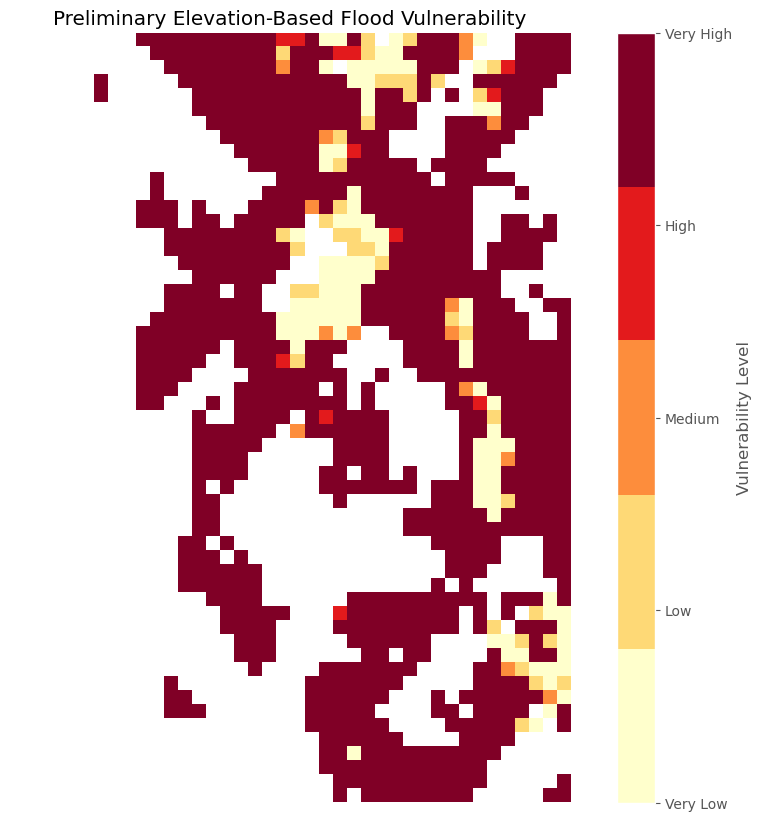


Vulnerability Distribution:
       Level  Pixels  Percentage
0  Very High     855   84.236453
1       High      12    1.182266
2     Medium      15    1.477833
3        Low      38    3.743842
4   Very Low      95    9.359606


/tmp/ipykernel_864416/881905782.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Level', y='Percentage', data=vuln_df,


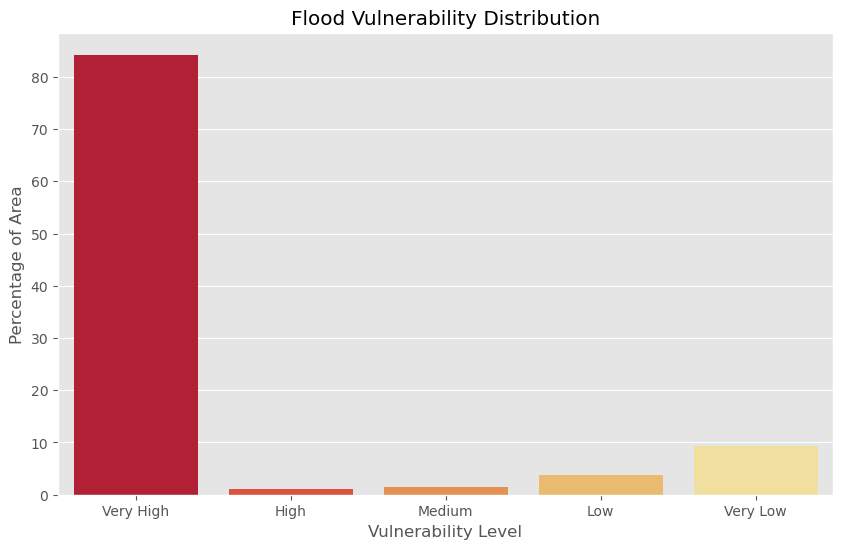

In [12]:
# Check if we have DEM and boundary data to perform a basic assessment
if dem_path.exists() and boundary_file.exists():
    try:
        print("Performing preliminary elevation-based vulnerability assessment...")
        
        # Load boundary
        boundary = gpd.read_file(boundary_file)
        
        # Determine if we have ward boundaries for zonal stats
        ward_level = False
        if mumbai_boundary_file.exists():
            wards = gpd.read_file(mumbai_boundary_file)
            if 'ward_id' in wards.columns:
                ward_level = True
        
        # Open the DEM
        with rasterio.open(dem_path) as src:
            dem = src.read(1)
            transform = src.transform
            
            # Handle nodata values
            if src.nodata is not None:
                dem = np.where(dem == src.nodata, np.nan, dem)
            
            # Create a simple vulnerability classification based on elevation
            # Low elevation = high vulnerability to flooding
            elevation_thresholds = [5, 10, 20, 50]
            vulnerability_classes = [5, 4, 3, 2, 1]  # 5 = highest vulnerability
            
            vuln_dem = np.zeros_like(dem)
            vuln_dem[:] = np.nan
            
            # Classify each pixel based on elevation
            vuln_dem[dem <= elevation_thresholds[0]] = vulnerability_classes[0]
            for i in range(1, len(elevation_thresholds)):
                vuln_dem[(dem > elevation_thresholds[i-1]) & (dem <= elevation_thresholds[i])] = vulnerability_classes[i]
            vuln_dem[dem > elevation_thresholds[-1]] = vulnerability_classes[-1]
            
            # Plot the vulnerability map
            fig, ax = plt.subplots(figsize=(12, 10))
            cmap = plt.cm.get_cmap('YlOrRd', 5)
            img = ax.imshow(vuln_dem, cmap=cmap)
            cbar = plt.colorbar(img, ax=ax, ticks=range(1, 6))
            cbar.set_label('Vulnerability Level')
            cbar.set_ticklabels(['Very Low', 'Low', 'Medium', 'High', 'Very High'])
            plt.title("Preliminary Elevation-Based Flood Vulnerability")
            plt.axis('off')
            plt.show()
            
            # Calculate vulnerable area percentages
            valid_pixels = np.sum(~np.isnan(vuln_dem))
            vulnerability_distribution = []
            
            for i, level in enumerate(vulnerability_classes):
                level_name = ['Very High', 'High', 'Medium', 'Low', 'Very Low'][i]
                pixel_count = np.sum(vuln_dem == level)
                percentage = (pixel_count / valid_pixels) * 100 if valid_pixels > 0 else 0
                vulnerability_distribution.append({
                    'Level': level_name,
                    'Pixels': pixel_count,
                    'Percentage': percentage
                })
            
            # Create a DataFrame and display
            vuln_df = pd.DataFrame(vulnerability_distribution)
            print("\nVulnerability Distribution:")
            print(vuln_df)
            
            # Plot vulnerability distribution
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Level', y='Percentage', data=vuln_df, 
                       palette=sns.color_palette('YlOrRd_r', 5))
            plt.title("Flood Vulnerability Distribution")
            plt.xlabel("Vulnerability Level")
            plt.ylabel("Percentage of Area")
            plt.show()
            
            # If we have ward boundaries, calculate ward-level statistics
            if ward_level:
                print("\nCalculating ward-level vulnerability statistics...")
                
                # Use zonal statistics to calculate mean vulnerability for each ward
                import rasterstats
                
                # Make sure wards are in same CRS as raster
                wards = wards.to_crs(src.crs)
                
                # Calculate zonal statistics
                zs = rasterstats.zonal_stats(wards, vuln_dem, affine=transform, stats=['mean', 'min', 'max'],
                                           nodata=np.nan)
                
                # Create a DataFrame
                ward_vuln = pd.DataFrame(zs)
                ward_vuln['ward_id'] = wards['ward_id']
                
                # Sort by mean vulnerability (descending)
                ward_vuln = ward_vuln.sort_values('mean', ascending=False)
                
                print("Ward-level vulnerability statistics:")
                print(ward_vuln)
                
                # Plot ward-level vulnerability
                fig, ax = plt.subplots(figsize=(12, 10))
                merged = wards.merge(ward_vuln, on='ward_id')
                merged.plot(column='mean', cmap='YlOrRd', linewidth=0.8, ax=ax, 
                           edgecolor='black', legend=True, 
                           legend_kwds={'label': 'Mean Vulnerability'})
                plt.title("Ward-Level Flood Vulnerability")
                plt.xlabel("Longitude")
                plt.ylabel("Latitude")
                plt.show()
                
                # Bar chart of ward vulnerabilities
                plt.figure(figsize=(12, 6))
                sns.barplot(x='ward_id', y='mean', data=ward_vuln)
                plt.title("Mean Flood Vulnerability by Ward")
                plt.xlabel("Ward ID")
                plt.ylabel("Mean Vulnerability Score")
                plt.xticks(rotation=90)
                plt.tight_layout()
                plt.show()
                
    except Exception as e:
        print(f"Error performing preliminary vulnerability assessment: {e}")
else:
    print("Cannot perform vulnerability assessment: Missing DEM or boundary data")




## 5. Data Gaps and Next Steps

Let's identify what's missing and what should be collected next:




In [13]:
print("Data Collection Status and Gaps:")

# Check for each required dataset
data_status = {
    "Administrative Boundaries": boundary_file.exists(),
    "Ward Boundaries": mumbai_boundary_file.exists(),
    "Digital Elevation Model": dem_path.exists(),
    "Road Network": (infra_dir / "mumbai_roads.shp").exists(),
    "Water Bodies": (infra_dir / "mumbai_water.shp").exists(),
    "Drainage Network": (infra_dir / "mumbai_drainage.shp").exists(),
    "Critical Infrastructure": (infra_dir / "mumbai_critical.shp").exists(),
    "Census Data": Path("data/raw/census/mumbai_ward_census.csv").exists(),
    "Rainfall Data": Path("data/raw/rainfall/mumbai_rainfall.csv").exists(),
}

# Create a DataFrame and display
status_df = pd.DataFrame({
    'Dataset': list(data_status.keys()),
    'Status': ['Available' if status else 'Missing' for status in data_status.values()]
})

print(status_df)



Data Collection Status and Gaps:
                     Dataset     Status
0  Administrative Boundaries  Available
1            Ward Boundaries  Available
2    Digital Elevation Model  Available
3               Road Network  Available
4               Water Bodies  Available
5           Drainage Network  Available
6    Critical Infrastructure  Available
7                Census Data    Missing
8              Rainfall Data    Missing


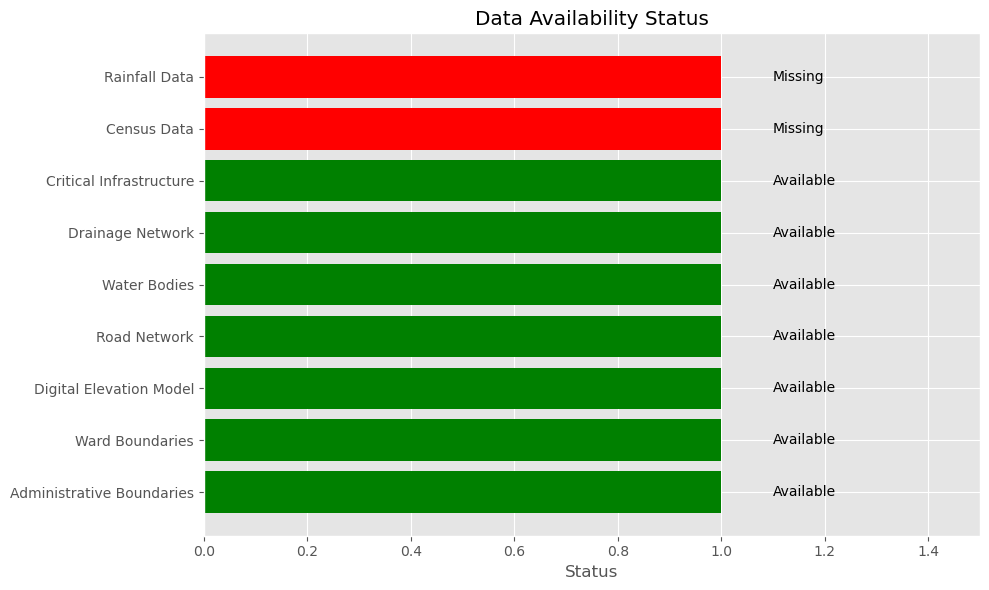

In [14]:
# Plot data availability
plt.figure(figsize=(10, 6))
colors = ['green' if status else 'red' for status in data_status.values()]
plt.barh(status_df['Dataset'], [1] * len(status_df), color=colors)
plt.title("Data Availability Status")
plt.xlabel("Status")
plt.xlim(0, 1.5)
for i, status in enumerate(status_df['Status']):
    plt.text(1.1, i, status, va='center')
plt.tight_layout()
plt.show()



In [15]:
# Next steps
print("\nRecommended Next Steps:")
for dataset, available in data_status.items():
    if not available:
        print(f"- Collect {dataset} data")

print("\nFor available data, the next steps are:")
print("1. Continue data preprocessing and cleaning")
print("2. Develop hydrological model components")
print("3. Integrate socioeconomic vulnerability data if census data is available")
print("4. Create composite vulnerability index")





Recommended Next Steps:
- Collect Census Data data
- Collect Rainfall Data data

For available data, the next steps are:
1. Continue data preprocessing and cleaning
2. Develop hydrological model components
3. Integrate socioeconomic vulnerability data if census data is available
4. Create composite vulnerability index


In [16]:
## 6. Conclusions and Recommendations


print("Initial Data Exploration Conclusions:")
print("1. Data collection status: Some key datasets have been successfully acquired.")
print("2. The available data allows for preliminary analysis but more datasets are needed for a comprehensive assessment.")
print("3. A basic elevation-based vulnerability assessment shows areas potentially at risk from flooding.")

print("\nRecommendations:")
print("1. Continue data collection for missing datasets")
print("2. Perform more detailed preprocessing of existing data")
print("3. Develop hydrological modeling components")
print("4. Begin integration of physical and socioeconomic vulnerability factors")
print("5. Set up the web dashboard framework for visualizing results")




Initial Data Exploration Conclusions:
1. Data collection status: Some key datasets have been successfully acquired.
2. The available data allows for preliminary analysis but more datasets are needed for a comprehensive assessment.
3. A basic elevation-based vulnerability assessment shows areas potentially at risk from flooding.

Recommendations:
1. Continue data collection for missing datasets
2. Perform more detailed preprocessing of existing data
3. Develop hydrological modeling components
4. Begin integration of physical and socioeconomic vulnerability factors
5. Set up the web dashboard framework for visualizing results


This notebook provides an initial exploration of the data collected so far and identifies gaps that need to be filled to complete the Mumbai Flood Vulnerability Assessment System.

In [17]:
df = pd.read_csv('data/raw/census/mumbai-census.csv')
df.head()

Sl No  State Code   State Name  District Code    District Name  \
0      1          27  MAHARASHTRA            518  Mumbai Suburban   
1      2          27  MAHARASHTRA            518  Mumbai Suburban   
2      3          27  MAHARASHTRA            518  Mumbai Suburban   
3      4          27  MAHARASHTRA            518  Mumbai Suburban   
4      5          27  MAHARASHTRA            518  Mumbai Suburban   

   Sub dist code                    Sub dist name  Town Code  \
0          99999  Greater Mumbai (M Corp.) (Part)     802794   
1          99999  Greater Mumbai (M Corp.) (Part)     802794   
2          99999  Greater Mumbai (M Corp.) (Part)     802794   
3          99999  Greater Mumbai (M Corp.) (Part)     802794   
4          99999  Greater Mumbai (M Corp.) (Part)     802794   

                  Town Name  Ward Code  Total Population  Total Males  \
0  Greater Mumbai (M Corp.)       1043             99427        55206   
1  Greater Mumbai (M Corp.)       1045            185572       101137   
2  Greater Mumbai (M Corp.)       1048            272240       149523   
3  Greater Mumbai (M Corp.)       1139             47123        26017   
4  Greater Mumbai (M Corp.)       1140             36739        18219   

   Total Females  SC Population  SC Males  SC Females  ST Population  \
0          44221           5137      2547        2590            588   
1          84435          18186      9300        8886           1802   
2         122717          11172      5932        5240           1790   
3          21106            563       286         277             75   
4          18520            394       183         211             73   

   ST Males  ST Females Ward Name  
0       326         262       H/E  
1      1037         765       H/E  
2      1084         706       H/E  
3        43          32       H/W  
4        37          36       H/W